In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import cv2

%matplotlib inline

In [2]:
def get_data(dataset_root_dir, sample_rate=1, crop=False):
    face_dir = os.path.join(dataset_root_dir, "face_data.npy")
    face_label_dir = os.path.join(dataset_root_dir, "face_label.npy")
    face = np.load(face_dir)
    face_label = np.load(face_label_dir)
    face_data = []
    for f in face:
        # face_data.append(np.int32((f-np.min(f))*255/(np.max(f)-np.min(f)) ))
        # face_data.append(f[:172,:])
        if crop:
            face_data.append(f[0:150,:])
        else:
            face_data.append(f)
    train_X = []
    train_Y = []
    test_X = []
    test_Y = []
    step = 11
    for i in range(0, len(face_data), step):
        idx = list(range(i, i + step))
        idx_train = random.sample(idx, sample_rate)
        # idx_train = idx[:sample_rate]
        idx_test = [i for i in idx if i not in idx_train]
        train_X += [face_data[i] for i in idx_train]
        test_X += [face_data[i] for i in idx_test]
        train_Y += [face_label[i] for i in idx_train]
        test_Y += [face_label[i] for i in idx_test]
    
    return np.array(train_X), np.array(train_Y), np.array(test_X), np.array(test_Y)

def get_avg_face(dataset):
    avg = np.mean(dataset, axis=1)
    return avg.reshape(avg.shape[0], -1)

def get_var_face(avg_face, dataset):
    result = dataset - np.tile(avg_face, dataset.shape[1])
    return result

def get_eigen_face(dataset):
    avg = get_avg_face(dataset)
    A = get_var_face(avg, dataset)
    AT_A = np.dot(A.T, A)
    AT_A_e_value, AT_A_e_vector = np.linalg.eig(AT_A)
    A_AT_e_value = AT_A_e_value
    A_AT_e_vector = np.dot(A,AT_A_e_vector)
    return A_AT_e_value, A_AT_e_vector

def calc_train_weight(A, vec, sample_rate=1, agg="mean"):
    W = np.dot(vec, A).T
    n_W = []
    for i in range(0, W.shape[0], sample_rate):
        if agg == "mean":
            v = np.mean(W[i:i+sample_rate], axis=0)
        else:
            v = abs_max_pooling(W[i:i+sample_rate])
        n_W.append(v)
    return np.array(n_W)


def calc_weight(A, vec):
    W = np.dot(vec, A).T
    return W

def test(test_X, avg_face, W, eigen_face, f='L1'):
    var_face = get_var_face(avg_face, test_X)
    test_W = calc_weight(var_face, eigen_face)
    loss_list = loss(test_W, W, f=f)
    return loss_list

def loss(test_W, W, f='L2'):
    loss_list = []
    for tw in test_W:
        l = []
        for i in range(len(W)):
            # each class loss
            l.append(loss_func(tw, W[i], f=f))
        loss_list.append(l)
    return loss_list
            

def loss_func(v1, v2, f='L1'):
    if f == 'L1':
        result = np.linalg.norm(v1-v2, ord=1)
    elif f == 'L2':
        result = np.linalg.norm(v1-v2, ord=2)
    elif f == 'cos':
        result = float(np.dot(v1, v2.T))/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return result

def abs_max_pooling(W):
    idx = np.argmax(np.abs(W), axis=0)
    l = []
    for i in range(len(idx)):
        l.append(W[idx[i], i])
        
    return np.array(l)

def classify(loss_list, spr=1,f="L1"):
    test_class = []
    for l in loss_list:
        idx = 0
        for i in range(len(l)):
            if f in ["L1","L2"]:
                if l[i] < l[idx]:
                    idx = i
            elif f in ["cos"]:
                if l[i] > l[idx]:
                    idx = i
        test_class.append(idx)
    return test_class

def normalization(mat):
    # 对行向量v归一化，使得每一项对平方和为1
    n_mat = []
    for v in mat:
        n_mat.append(v/np.linalg.norm(v, ord=2))
    return np.array(n_mat)

def show_img(x):
    plt.imshow(x.reshape(243, 320), cmap=plt.cm.gray)
    plt.show()
    return
   
def show_img_small(x):
    plt.imshow(x.reshape(172, 320), cmap=plt.cm.gray)
    plt.show()
    return

def eigenface(spr=1, f="cos", agg="mean", eigen=[2,10], crop=False):
    dataset_root_dir = "../data/"
    train_X, train_Y, test_X, test_Y = get_data(dataset_root_dir, sample_rate=spr, crop=crop)
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1]*train_X.shape[2]).T
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1]*test_X.shape[2]).T
    val, vec = get_eigen_face(train_X)
    a = sorted(zip(val,vec.T), reverse=True)[eigen[0]:eigen[1]]
    _, vec = zip(*a)
    vec = np.array(vec)
    vec = normalization(vec)
    avg_face = get_avg_face(train_X)
    var_face = get_var_face(avg_face, train_X)
    if agg in ["mean", "absmax"]:
        W = calc_train_weight(var_face, vec, sample_rate=spr, agg=agg)
    else:
        W = calc_weight(var_face, vec)
    
    loss_list = test(test_X, avg_face, W, vec, f=f)
    test_class = []
    if agg in ["mean", "absmax"]:
        for l in loss_list:
            idx = 0
            for i in range(len(l)):
                if f in ["L1","L2"]:
                    if l[i] < l[idx]:
                        idx = i
                elif f in ["cos"]:
                    if l[i] > l[idx]:
                        idx = i
            test_class.append(idx)
    else:

        for l in loss_list:
            idx = 0
            for i in range(len(l)):
                if f in ["L1","L2"]:
                    if l[i] < l[idx]:
                        idx = i
                elif f in ["cos"]:
                    if l[i] > l[idx]:
                        idx = i
            test_class.append(idx // spr)
    
    total = len(test_Y)
    acc = 0
    for i, j in zip(test_class, test_Y):
        # print(j, i)
        if i == j:
            acc += 1
    return acc/total

In [3]:


# print(train_X.shape)
# print(train_X[:, 1])
# show_img(train_X[:, 10])



In [4]:
train_X, train_Y, test_X, test_Y = get_data(dataset_root_dir, sample_rate=spr, crop=False)
# print(train_X.shape)



NameError: name 'dataset_root_dir' is not defined

In [241]:

eigenface(spr=1, f="L2", agg="mean", eigen=[2,10], crop=False)

0.5066666666666667

In [321]:
eigen_list = [[0,8], [2,10], [3,11], [2,-3], [5, -3]]
baseline=[]
for l in eigen_list:
    tmp = []
    for i in range(5):
        v = eigenface(spr=i+1, f="L2", agg="mean", eigen=l, crop=False)
        tmp.append(v)
    baseline.append(tmp)

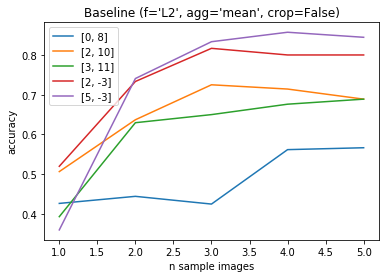

In [322]:
plt.title("Baseline (f='L2', agg='mean', crop=False)")
plt.xlabel('n sample images')
plt.ylabel('accuracy')
x = range(1,6)

for y,l in zip(baseline, eigen_list):
    plt.plot(x,y,label=str(l))
    plt.legend(loc='upper left')
plt.show()

In [281]:
loss_f = ["L1", "L2", "cos"]
eig = [2,10]
loss_func_list = []
for func in loss_f:
    tmp = []
    for i in range(1,6):
        v = eigenface(spr=i, f=func, agg="mean", eigen=eig, crop=False)
        tmp.append(v)
    loss_func_list.append(tmp)

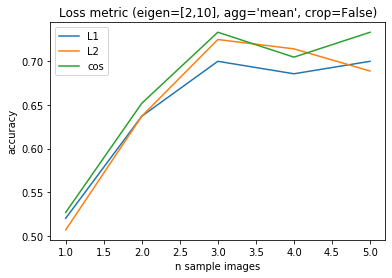

In [284]:
plt.title("Loss metric (eigen=[2,10], agg='mean', crop=False)")
plt.xlabel('n sample images')
plt.ylabel('accuracy')
x = range(1,6)

for y,l in zip(loss_func_list, loss_f):
    plt.plot(x,y,label=str(l))
    plt.legend(loc='upper left')
plt.show()

In [292]:
agg_list = ["mean", "absmax", "none"]
eig = [2,10]
agg_acc = []
for agg in agg_list:
    tmp = []
    for i in range(1,6):
        v = eigenface(spr=i, f="L2", agg=agg, eigen=eig, crop=False)
        tmp.append(v)
    agg_acc.append(tmp)

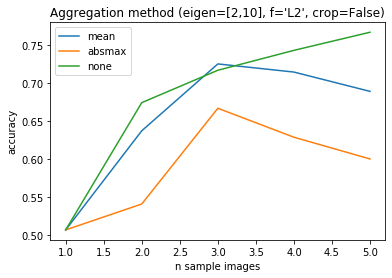

In [294]:
plt.title("Aggregation method (eigen=[2,10], f='L2', crop=False)")
plt.xlabel('n sample images')
plt.ylabel('accuracy')
x = range(1,6)

for y,l in zip(agg_acc, agg_list):
    plt.plot(x,y,label=str(l))
    plt.legend(loc='upper left')
plt.show()

In [17]:
crop_list = [True, False]
eig = [2,13]
crop_acc = []
for crop in crop_list:
    tmp = []
    for i in range(1,6):
        v = eigenface(spr=i, f="L2", agg="mean", eigen=eig, crop=crop)
        tmp.append(v)
    crop_acc.append(tmp)

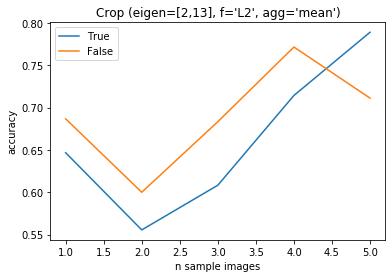

In [18]:
plt.title("Crop (eigen=[2,13], f='L2', agg='mean')")
plt.xlabel('n sample images')
plt.ylabel('accuracy')
x = range(1,6)

for y,l in zip(crop_acc, crop_list):
    plt.plot(x,y,label=str(l))
    plt.legend(loc='upper left')
plt.show()

In [7]:
metric_list = ["L1", "L2", "cos"]
agg_list = ["mean", "absmax", "none"]
crop_list = [True, False]
eigen = [5,-5]
accs = []

for metric in metric_list:
    for agg in agg_list:
        for crop in crop_list:
            tmp = []
            for i in range(1,6):
                v = eigenface(spr=i, f=metric, agg=agg, eigen=eigen, crop=crop)
                tmp.append(v)
            accs.append(tmp)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:87: ComplexWarning: Casting complex values to real discards the imaginary part


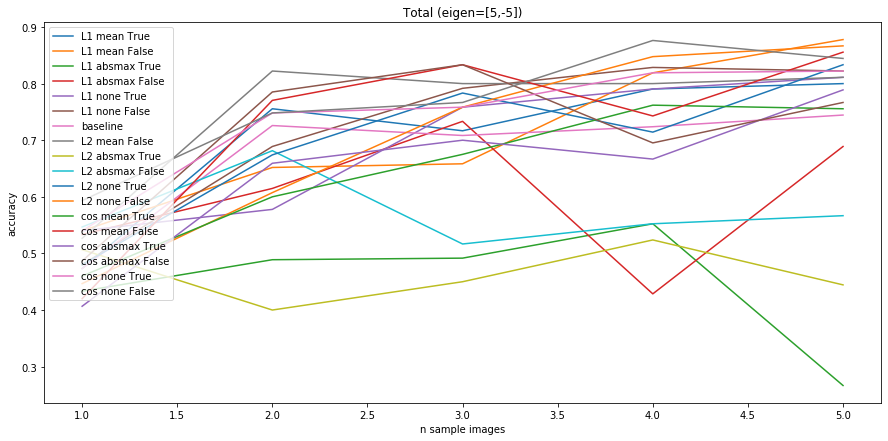

In [8]:
plt.figure(figsize=(15, 7))
plt.title("Total (eigen=[5,-5])")
plt.xlabel('n sample images')
plt.ylabel('accuracy')

x = range(1,6)

cnt = 0

for metric in metric_list:
    for agg in agg_list:
        for crop in crop_list:
            if metric=="L2" and agg=="mean" and crop==True:
                plt.plot(x, accs[cnt], label="baseline")
            else:
                plt.plot(x, accs[cnt], label=" ".join([metric, agg, str(crop)]))
            plt.legend(loc='upper left')
            
            cnt += 1
plt.show()


In [88]:
val, vec = get_eigen_face(train_X)
show_img(vec[:,-1])
print("val[-1]: ",val[-1])
a = sorted(zip(val,vec.T), reverse=True)[5:20]
_, vec = zip(*a)
vec = np.array(vec)
vec = normalization(vec)
print(len(vec))
print(vec.shape)
avg_face = get_avg_face(train_X)
var_face = get_var_face(avg_face, train_X)
W = calc_train_weight(var_face, vec, sample_rate=spr)
# W = calc_weight(var_face, vec)
print(W.shape)
loss_list = test(test_X, avg_face, W, vec, f="L2")
print(vec[0])
show_img(vec[0])
test_class = []
for l in loss_list:
    idx = 0
    for i in range(len(l)):
        if l[i] < l[idx]:
            idx = i
    test_class.append(idx)
print(len(loss_list[0]))

15


In [89]:
total = len(test_Y)
acc = 0
for i, j in zip(test_class, test_Y):
    print(j, i)
    if i == j:
        acc += 1
print(acc/total)

0 0
0 0
0 2
0 0
0 1
0 0
0 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
2 11
2 2
2 2
2 2
2 2
2 2
2 2
2 6
3 2
3 3
3 14
3 3
3 3
3 3
3 3
3 3
4 4
4 4
4 7
4 4
4 4
4 4
4 4
4 4
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
6 6
6 6
6 6
6 6
6 6
6 12
6 6
6 6
7 7
7 6
7 14
7 7
7 9
7 14
7 7
7 7
8 14
8 2
8 8
8 8
8 14
8 8
8 14
8 8
9 2
9 2
9 9
9 9
9 2
9 9
9 9
9 9
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
11 1
11 1
11 1
11 1
11 14
11 11
11 11
11 4
12 12
12 12
12 12
12 12
12 12
12 12
12 12
12 12
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
14 14
14 14
14 14
14 14
14 6
14 2
14 14
14 6
0.7666666666666667
